# Brain Tumour Image Segmentation 

Using Kaggle brain tumour dataset


## Import libraries and data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import cv2
from skimage import io
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler, normalize
import os
import glob
import random
%matplotlib inline


2024-04-25 13:01:53.844293: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
data_path = "data/kaggle_3m/" 
brain_df = pd.read_csv(data_path+'data_mask.csv')

In [3]:
brain_df.info() 
brain_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   patient_id  3929 non-null   object
 1   image_path  3929 non-null   object
 2   mask_path   3929 non-null   object
 3   mask        3929 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 122.9+ KB


patient_id                                         image_path  \
0  TCGA_CS_5395_19981004  TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif   
1  TCGA_CS_5395_19981004  TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif   
2  TCGA_CS_5395_19981004  TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif   
3  TCGA_CS_5395_19981004  TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1.tif   
4  TCGA_CS_5395_19981004  TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1.tif   

                                           mask_path  mask  
0  TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_...     0  
1  TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_...     0  
2  TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_...     0  
3  TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1_...     0  
4  TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1_...     0

In [9]:
brain_df.mask_path[1] 
# brain_df.image_path[1]

'TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_mask.tif'

In [5]:
brain_df['mask'].value_counts()

mask
0    2556
1    1373
Name: count, dtype: int64

Imbalanced data - oh well 

## Data visualisation


In [6]:
brain_df['mask'].value_counts().index

Index([0, 1], dtype='int64', name='mask')

In [7]:
# Plot bar chart using plotly 

import plotly.graph_objects as go 

fig = go.Figure([go.Bar(x = brain_df['mask'].value_counts().index, y = brain_df['mask'].value_counts())])
fig.update_traces(marker_color = 'rgb(0,200,0)', marker_line_color = 'rgb(0,255,0)', marker_line_width = 7, opacity = 0.6)
fig.show()

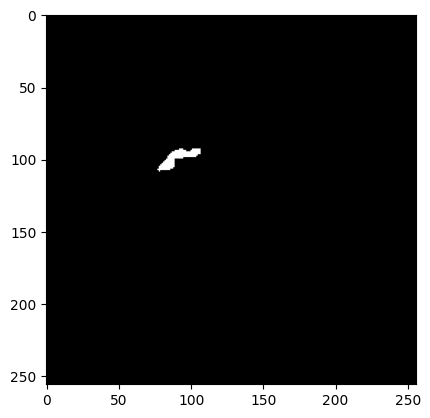

In [16]:
plt.imshow(cv2.imread(data_path+brain_df.mask_path[623]))

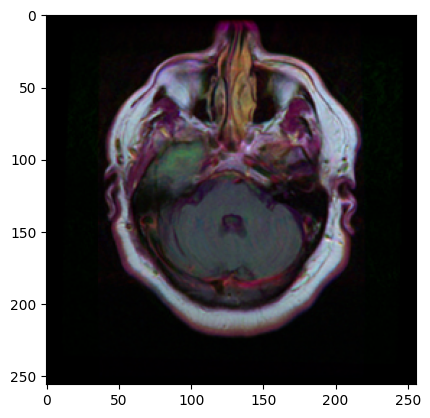

In [18]:
plt.imshow(cv2.imread(data_path+brain_df.image_path[623]))


In [20]:
cv2.imread(data_path+brain_df.mask_path[623]).max()


255

In [21]:
cv2.imread(data_path+brain_df.mask_path[623]).min()


0

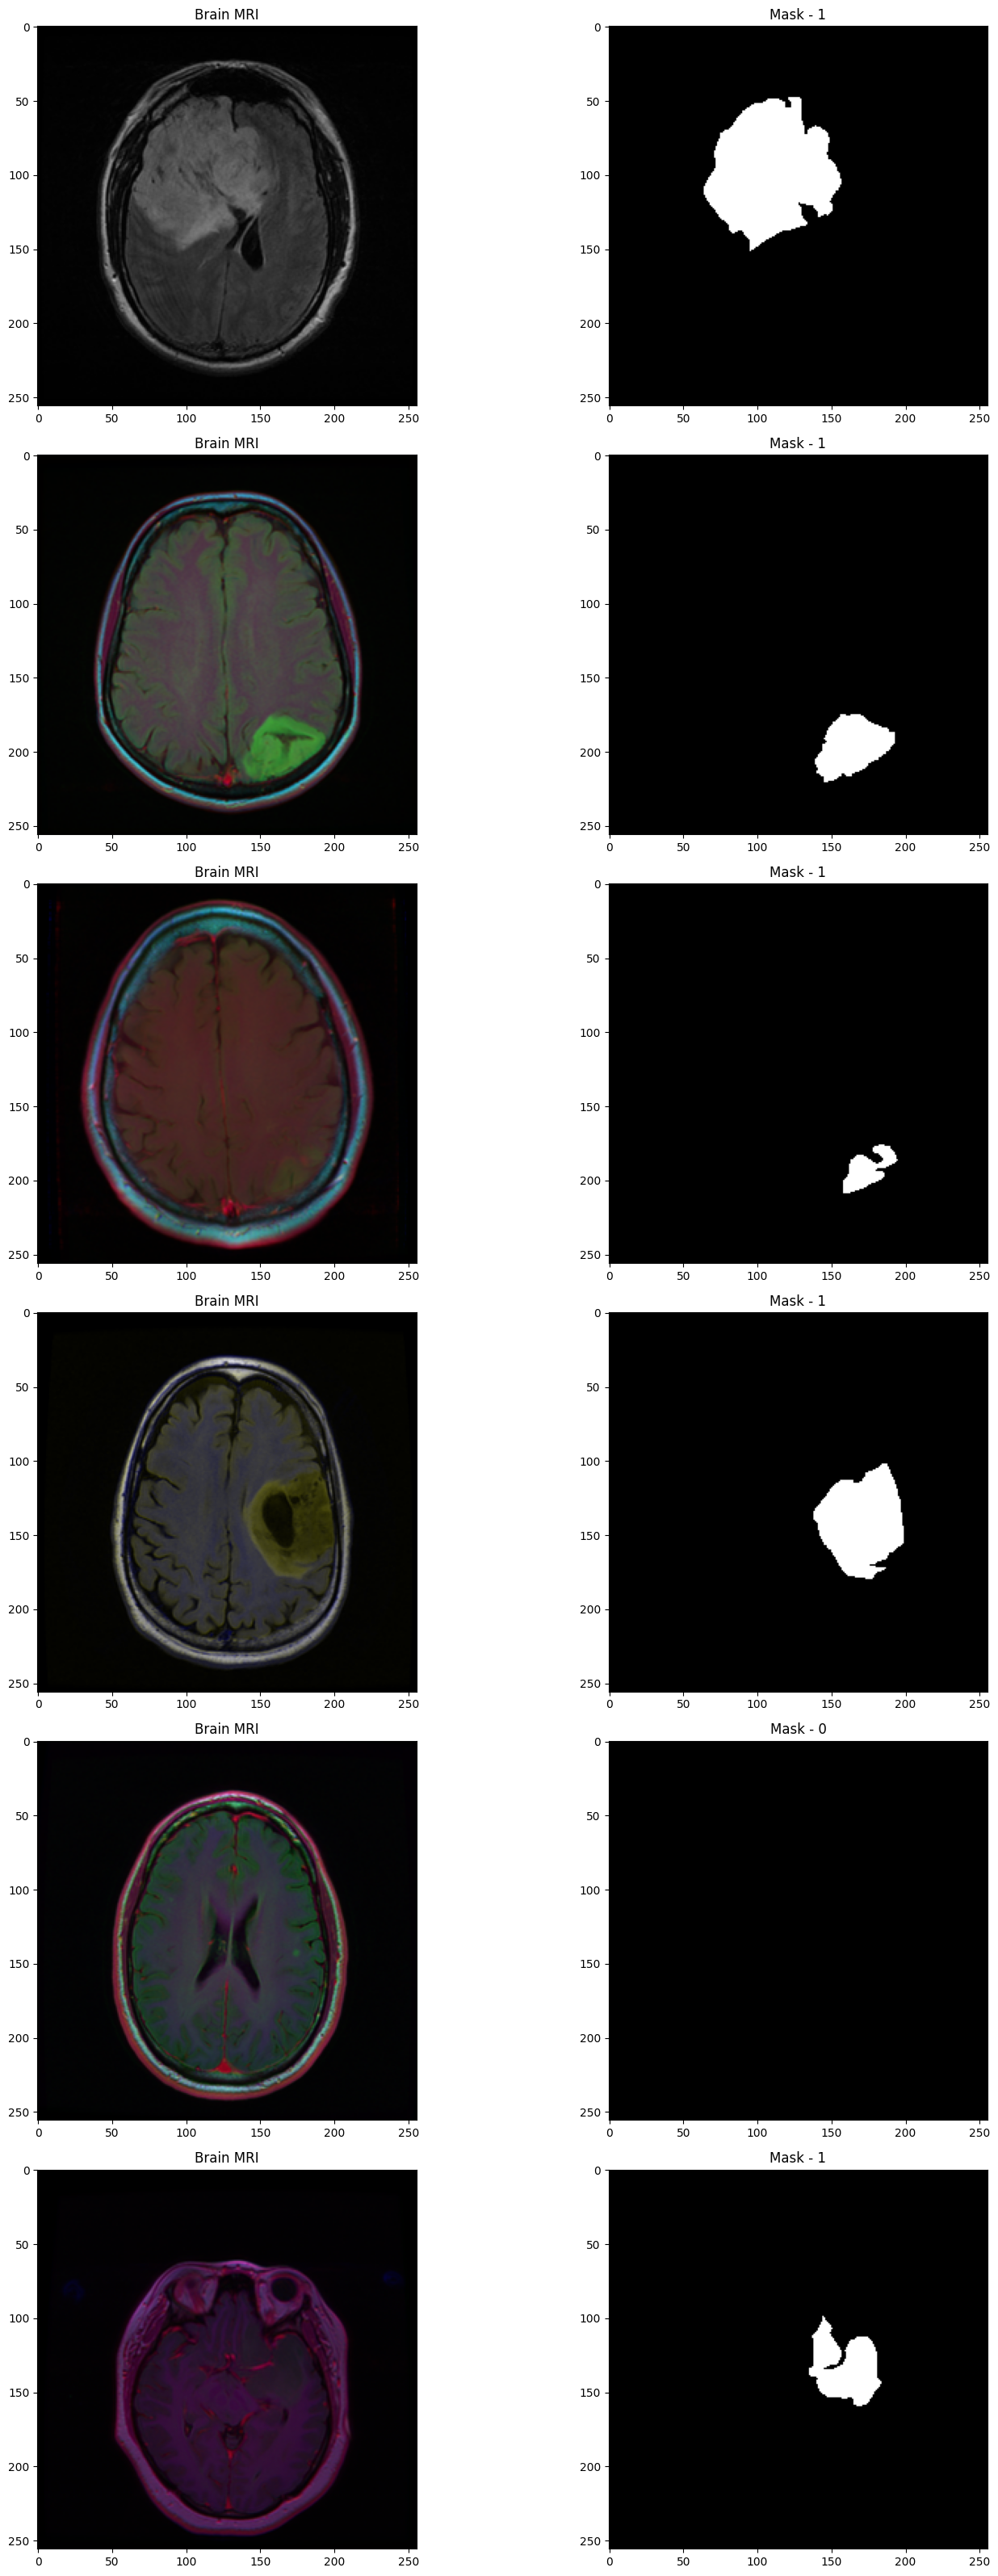

In [24]:
import random
fig, axs = plt.subplots(6,2, figsize=(16,32))
count = 0
for x in range(6):
  i = random.randint(0, len(brain_df)) # select a random index
  axs[count][0].title.set_text("Brain MRI") # set title
  axs[count][0].imshow(cv2.imread(data_path+brain_df.image_path[i])) # show MRI
  axs[count][1].title.set_text("Mask - " + str(brain_df['mask'][i])) # plot title on the mask (0 or 1)
  axs[count][1].imshow(cv2.imread(data_path+brain_df.mask_path[i])) # Show corresponding mask
  count += 1

fig.tight_layout()


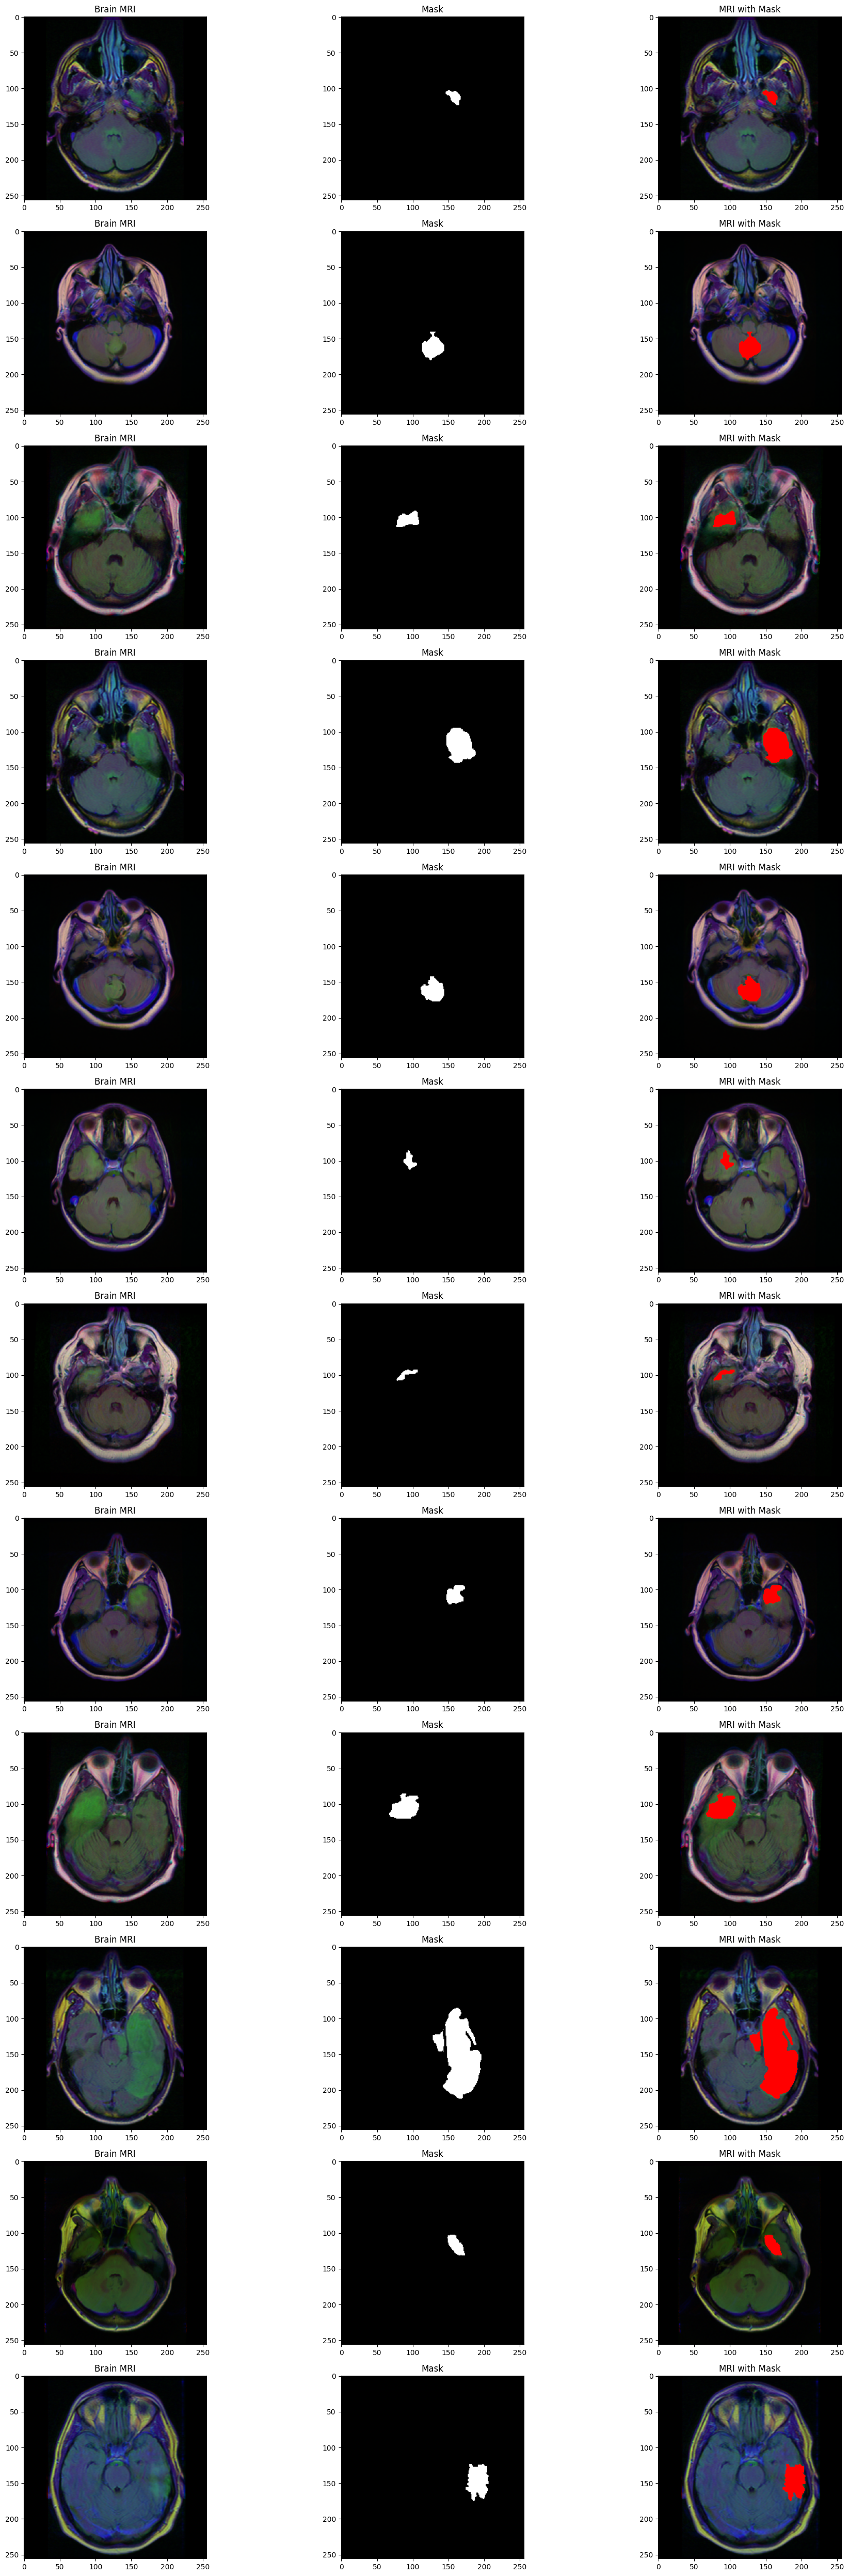

In [25]:
count = 0
fig, axs = plt.subplots(12,3, figsize=(20,50))
for i in range(len(brain_df)):
  if brain_df['mask'][i] == 1 and count < 12:
  # read the images
    img = io.imread(data_path+brain_df.image_path[i])
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axs[count][0].title.set_text("Brain MRI")
    axs[count][0].imshow(img)

    # obtain the mask for the image
    mask = io.imread(data_path+brain_df.mask_path[i])
    axs[count][1].title.set_text("Mask")
    axs[count][1].imshow(mask, cmap = 'gray')

    # replace the values in the image with red color (255,0,0) if any mask pixel in the mask was = 255
    img[mask == 255] = (255,0,0)
    axs[count][2].title.set_text("MRI with Mask")
    axs[count][2].imshow(img)
    count += 1

fig.tight_layout()


In [26]:
brain_df_train = brain_df.drop(columns = ['patient_id'])
brain_df_train.shape

(3929, 3)

In [27]:
brain_df_train['mask'] = brain_df_train['mask'].apply(lambda x: str(x))

In [28]:
from sklearn.model_selection import train_test_split 

train, test = train_test_split(brain_df_train, test_size = 0.15)

In [29]:
!pip install keras_preprocessing

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 522.0 kB/s eta 0:00:001m? eta -:--:--


In [31]:
from keras_preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255., validation_split = 0.15)

In [33]:
train_generator=datagen.flow_from_dataframe(
dataframe=train,
directory= data_path+'./',
x_col='image_path',
y_col='mask',
subset="training",
batch_size=16,
shuffle=True,
class_mode="categorical",
target_size=(256,256))


valid_generator=datagen.flow_from_dataframe(
dataframe=train,
directory= data_path+'./',
x_col='image_path',
y_col='mask',
subset="validation",
batch_size=16,
shuffle=True,
class_mode="categorical",
target_size=(256,256))

# Create a data generator for test images
test_datagen=ImageDataGenerator(rescale=1./255.)

test_generator=test_datagen.flow_from_dataframe(
dataframe=test,
directory= data_path+'./',
x_col='image_path',
y_col='mask',
batch_size=16,
shuffle=False,
class_mode='categorical',
target_size=(256,256))


Found 2839 validated image filenames belonging to 2 classes.
Found 500 validated image filenames belonging to 2 classes.
Found 590 validated image filenames belonging to 2 classes.


In [40]:
basemodel = ResNet50(weights = 'imagenet', include_top = False, input_tensor = Input(shape=(256,256,3)))

In [41]:
basemodel.summary()


Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

                                                                                                  
 conv2_block3_1_conv (Conv2  (None, 64, 64, 64)           16448     ['conv2_block2_out[0][0]']    
 D)                                                                                               
                                                                                                  
 conv2_block3_1_bn (BatchNo  (None, 64, 64, 64)           256       ['conv2_block3_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv2_block3_1_relu (Activ  (None, 64, 64, 64)           0         ['conv2_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv2_blo

 ation)                                                                                           
                                                                                                  
 conv3_block2_3_conv (Conv2  (None, 32, 32, 512)          66048     ['conv3_block2_2_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv3_block2_3_bn (BatchNo  (None, 32, 32, 512)          2048      ['conv3_block2_3_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv3_block2_add (Add)      (None, 32, 32, 512)          0         ['conv3_block1_out[0][0]',    
                                                                     'conv3_block2_3_bn[0][0]']   
          

 conv4_block1_2_conv (Conv2  (None, 16, 16, 256)          590080    ['conv4_block1_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv4_block1_2_bn (BatchNo  (None, 16, 16, 256)          1024      ['conv4_block1_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block1_2_relu (Activ  (None, 16, 16, 256)          0         ['conv4_block1_2_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_block1_0_conv (Conv2  (None, 16, 16, 1024)         525312    ['conv3_block4_out[0][0]']    
 D)       

                                                                                                  
 conv4_block3_out (Activati  (None, 16, 16, 1024)         0         ['conv4_block3_add[0][0]']    
 on)                                                                                              
                                                                                                  
 conv4_block4_1_conv (Conv2  (None, 16, 16, 256)          262400    ['conv4_block3_out[0][0]']    
 D)                                                                                               
                                                                                                  
 conv4_block4_1_bn (BatchNo  (None, 16, 16, 256)          1024      ['conv4_block4_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_blo

 D)                                                                                               
                                                                                                  
 conv4_block6_3_bn (BatchNo  (None, 16, 16, 1024)         4096      ['conv4_block6_3_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block6_add (Add)      (None, 16, 16, 1024)         0         ['conv4_block5_out[0][0]',    
                                                                     'conv4_block6_3_bn[0][0]']   
                                                                                                  
 conv4_block6_out (Activati  (None, 16, 16, 1024)         0         ['conv4_block6_add[0][0]']    
 on)                                                                                              
          

 conv5_block3_1_relu (Activ  (None, 8, 8, 512)            0         ['conv5_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv5_block3_2_conv (Conv2  (None, 8, 8, 512)            2359808   ['conv5_block3_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv5_block3_2_bn (BatchNo  (None, 8, 8, 512)            2048      ['conv5_block3_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv5_block3_2_relu (Activ  (None, 8, 8, 512)            0         ['conv5_block3_2_bn[0][0]']   
 ation)   

In [42]:
for layer in basemodel.layers:
  layers.trainable = False


In [43]:
# Add classification head to the base model

headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size = (4,4))(headmodel)
headmodel = Flatten(name= 'flatten')(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)#
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
#headmodel = Dense(256, activation = "relu")(headmodel)
#headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(2, activation = 'softmax')(headmodel) # Binary classification

model = Model(inputs = basemodel.input, outputs = headmodel)


In [44]:
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

                                                                                                  
 conv2_block3_1_conv (Conv2  (None, 64, 64, 64)           16448     ['conv2_block2_out[0][0]']    
 D)                                                                                               
                                                                                                  
 conv2_block3_1_bn (BatchNo  (None, 64, 64, 64)           256       ['conv2_block3_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv2_block3_1_relu (Activ  (None, 64, 64, 64)           0         ['conv2_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv2_blo

 ation)                                                                                           
                                                                                                  
 conv3_block2_3_conv (Conv2  (None, 32, 32, 512)          66048     ['conv3_block2_2_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv3_block2_3_bn (BatchNo  (None, 32, 32, 512)          2048      ['conv3_block2_3_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv3_block2_add (Add)      (None, 32, 32, 512)          0         ['conv3_block1_out[0][0]',    
                                                                     'conv3_block2_3_bn[0][0]']   
          

 conv4_block1_2_conv (Conv2  (None, 16, 16, 256)          590080    ['conv4_block1_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv4_block1_2_bn (BatchNo  (None, 16, 16, 256)          1024      ['conv4_block1_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block1_2_relu (Activ  (None, 16, 16, 256)          0         ['conv4_block1_2_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_block1_0_conv (Conv2  (None, 16, 16, 1024)         525312    ['conv3_block4_out[0][0]']    
 D)       

                                                                                                  
 conv4_block3_out (Activati  (None, 16, 16, 1024)         0         ['conv4_block3_add[0][0]']    
 on)                                                                                              
                                                                                                  
 conv4_block4_1_conv (Conv2  (None, 16, 16, 256)          262400    ['conv4_block3_out[0][0]']    
 D)                                                                                               
                                                                                                  
 conv4_block4_1_bn (BatchNo  (None, 16, 16, 256)          1024      ['conv4_block4_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_blo

 D)                                                                                               
                                                                                                  
 conv4_block6_3_bn (BatchNo  (None, 16, 16, 1024)         4096      ['conv4_block6_3_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block6_add (Add)      (None, 16, 16, 1024)         0         ['conv4_block5_out[0][0]',    
                                                                     'conv4_block6_3_bn[0][0]']   
                                                                                                  
 conv4_block6_out (Activati  (None, 16, 16, 1024)         0         ['conv4_block6_add[0][0]']    
 on)                                                                                              
          

 conv5_block3_1_relu (Activ  (None, 8, 8, 512)            0         ['conv5_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv5_block3_2_conv (Conv2  (None, 8, 8, 512)            2359808   ['conv5_block3_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv5_block3_2_bn (BatchNo  (None, 8, 8, 512)            2048      ['conv5_block3_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv5_block3_2_relu (Activ  (None, 8, 8, 512)            0         ['conv5_block3_2_bn[0][0]']   
 ation)   

In [45]:
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics= ["accuracy"])



In [46]:
# use early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# save the best model with least validation loss
checkpointer = ModelCheckpoint(filepath="classifier-resnet-weights.hdf5", verbose=1, save_best_only=True)
     


In [ ]:
history = model.fit(train_generator, steps_per_epoch= train_generator.n // 16, epochs = 1, validation_data= valid_generator, validation_steps= valid_generator.n // 16, callbacks=[checkpointer, earlystopping])


 13/177 [=>............................] - ETA: 15:32 - loss: 2.0512 - accuracy: 0.6154

In [ ]:
model_json = model.to_json()
with open("classifier-resnet-model.json","w") as json_file:
  json_file.write(model_json)